In [1]:
# Initialization: Load shared functions and simulated data

# Load shared functions
!curl -O https://raw.githubusercontent.com/Fraud-Detection-Handbook/fraud-detection-handbook/main/Chapter_References/shared_functions.py
%run shared_functions.py

# Get simulated data from Github repository
if not os.path.exists("simulated-data-transformed"):
    !git clone https://github.com/Fraud-Detection-Handbook/simulated-data-transformed


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 63257  100 63257    0     0   281k      0 --:--:-- --:--:-- --:--:--  282k


In [2]:
# 2 fraudulent and 8 genuine transactions
true_labels = [1,1,0,0,0,0,0,0,0,0]

# Probability of fraud for each transaction
fraud_probabilities = [0.9,0.35,0.45,0.4,0.2,0.2,0.2,0.1,0.1,0]

In [3]:
unique_thresholds = [1.1]+list(set(fraud_probabilities))
unique_thresholds.sort(reverse=True)
unique_thresholds


[1.1, 0.9, 0.45, 0.4, 0.35, 0.2, 0.1, 0]

In [4]:
performance_metrics=threshold_based_metrics(fraud_probabilities, true_labels, unique_thresholds)
performance_metrics[['Threshold','TPR','FPR']]

,Threshold,TPR,FPR
0,1.10,0.0,0.000
1,0.90,0.5,0.000
2,0.45,0.5,0.125
3,0.40,0.5,0.250
4,0.35,1.0,0.250
5,0.20,1.0,0.625
6,0.10,1.0,0.875
7,0.00,1.0,1.000


In [5]:
FPR_list, TPR_list, threshold = sklearn.metrics.roc_curve(true_labels, fraud_probabilities, drop_intermediate=False)
FPR_list, TPR_list, threshold

(array([0.   , 0.   , 0.125, 0.25 , 0.25 , 0.625, 0.875, 1.   ]),
 array([0. , 0.5, 0.5, 0.5, 1. , 1. , 1. , 1. ]),
 array([1.9 , 0.9 , 0.45, 0.4 , 0.35, 0.2 , 0.1 , 0.  ]))

In [6]:
%%capture
def get_template_roc_curve(ax, title,fs,random=True):

    ax.set_title(title, fontsize=fs)
    ax.set_xlim([-0.01, 1.01])
    ax.set_ylim([-0.01, 1.01])

    ax.set_xlabel('False Positive Rate', fontsize=fs)
    ax.set_ylabel('True Positive Rate', fontsize=fs)

    if random:
        ax.plot([0, 1], [0, 1],'r--',label="AUC ROC Random = 0.5")

ROC_AUC = metrics.auc(FPR_list, TPR_list)

roc_curve, ax = plt.subplots(figsize=(5,5))
get_template_roc_curve(ax, "Receiver Operating Characteristic (ROC) Curve",fs=15)
ax.plot(FPR_list, TPR_list, 'b', color='blue', label = 'AUC ROC Classifier = {0:0.3f}'.format(ROC_AUC))
ax.legend(loc = 'lower right')

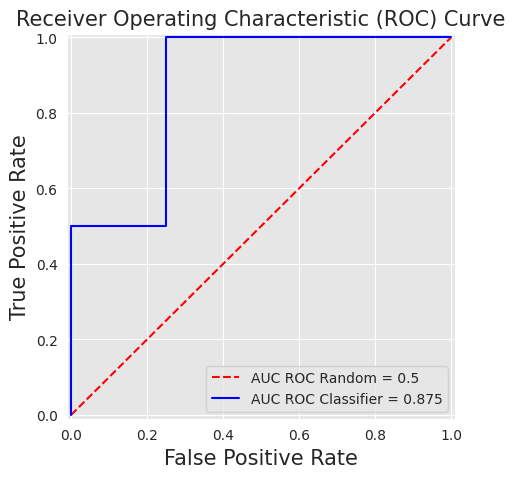

In [7]:
roc_curve

In [8]:
# 2 fraudulent and 8 genuine transactions
true_labels = [1,1,0,0,0,0,0,0,0,0]

# Probability of fraud for each transaction
fraud_probabilities = [0.5]*10
FPR_list, TPR_list, threshold = metrics.roc_curve(true_labels, fraud_probabilities, drop_intermediate=False)
FPR_list, TPR_list, threshold

(array([0., 1.]), array([0., 1.]), array([1.5, 0.5]))

In [9]:
%%capture

ROC_AUC = metrics.auc(FPR_list, TPR_list)

roc_curve, ax = plt.subplots(figsize=(5,5))
get_template_roc_curve(ax, "Receiver Operating Characteristic (ROC) Curve\n Random classifier",fs=15,random=False)
ax.plot(FPR_list, TPR_list, 'b', color='blue', label = 'AUC ROC Classifier = {0:0.3f}'.format(ROC_AUC))
ax.legend(loc = 'lower right')

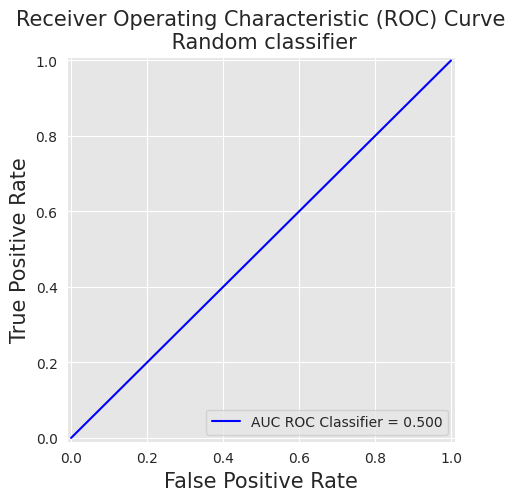

In [10]:
roc_curve

In [11]:
# Load data from the 2018-07-25 to the 2018-08-14

DIR_INPUT='./simulated-data-transformed/data'

BEGIN_DATE = "2018-07-25"
END_DATE = "2018-08-14"

print("Load  files")
%time transactions_df=read_from_files(DIR_INPUT, BEGIN_DATE, END_DATE)
print("{0} transactions loaded, containing {1} fraudulent transactions".format(len(transactions_df),transactions_df.TX_FRAUD.sum()))


start_date_training = datetime.datetime.strptime("2018-07-25", "%Y-%m-%d")
delta_train=delta_delay=delta_test=7

(train_df,test_df)=get_train_test_set(transactions_df,start_date_training,
                                      delta_train=delta_train,delta_delay=delta_delay,delta_test=delta_test)

output_feature="TX_FRAUD"

input_features=['TX_AMOUNT','TX_DURING_WEEKEND', 'TX_DURING_NIGHT', 'CUSTOMER_ID_NB_TX_1DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW', 'CUSTOMER_ID_NB_TX_7DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW', 'CUSTOMER_ID_NB_TX_30DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW', 'TERMINAL_ID_NB_TX_1DAY_WINDOW',
       'TERMINAL_ID_RISK_1DAY_WINDOW', 'TERMINAL_ID_NB_TX_7DAY_WINDOW',
       'TERMINAL_ID_RISK_7DAY_WINDOW', 'TERMINAL_ID_NB_TX_30DAY_WINDOW',
       'TERMINAL_ID_RISK_30DAY_WINDOW']

classifiers_dictionary={'Logistic regression':sklearn.linear_model.LogisticRegression(random_state=0),
                        'Decision tree with depth of two':sklearn.tree.DecisionTreeClassifier(max_depth=2,random_state=0),
                        'Decision tree - unlimited depth':sklearn.tree.DecisionTreeClassifier(random_state=0),
                        'Random forest':sklearn.ensemble.RandomForestClassifier(random_state=0,n_jobs=-1),
                        'XGBoost':xgboost.XGBClassifier(random_state=0,n_jobs=-1),
                       }

fitted_models_and_predictions_dictionary={}

for classifier_name in classifiers_dictionary:

    start_time=time.time()
    model_and_predictions = fit_model_and_get_predictions(classifiers_dictionary[classifier_name], train_df, test_df,
                                                          input_features=input_features,
                                                          output_feature=output_feature)

    print("Time to fit the "+classifier_name+" model: "+str(round(time.time()-start_time,2)))

    fitted_models_and_predictions_dictionary[classifier_name]=model_and_predictions


Load  files
CPU times: user 123 ms, sys: 239 ms, total: 362 ms
Wall time: 379 ms
201295 transactions loaded, containing 1792 fraudulent transactions
Time to fit the Logistic regression model: 0.78
Time to fit the Decision tree with depth of two model: 0.27
Time to fit the Decision tree - unlimited depth model: 1.39
Time to fit the Random forest model: 14.79
Time to fit the XGBoost model: 0.98


In [12]:
%%capture
roc_curve, ax = plt.subplots(1, 1, figsize=(5,5))

cmap = plt.get_cmap('jet')
colors={'Logistic regression':cmap(0), 'Decision tree with depth of two':cmap(200),
        'Decision tree - unlimited depth':cmap(250),
        'Random forest':cmap(70), 'XGBoost':cmap(40)}

get_template_roc_curve(ax,title='Receiver Operating Characteristic Curve\nTest data',fs=15)

for classifier_name in classifiers_dictionary:

    model_and_predictions=fitted_models_and_predictions_dictionary[classifier_name]

    FPR_list, TPR_list, threshold = metrics.roc_curve(test_df[output_feature], model_and_predictions['predictions_test'])
    ROC_AUC = metrics.auc(FPR_list, TPR_list)

    ax.plot(FPR_list, TPR_list, 'b', color=colors[classifier_name], label = 'AUC ROC {0}= {1:0.3f}'.format(classifier_name,ROC_AUC))
    ax.legend(loc = 'upper left',bbox_to_anchor=(1.05, 1))


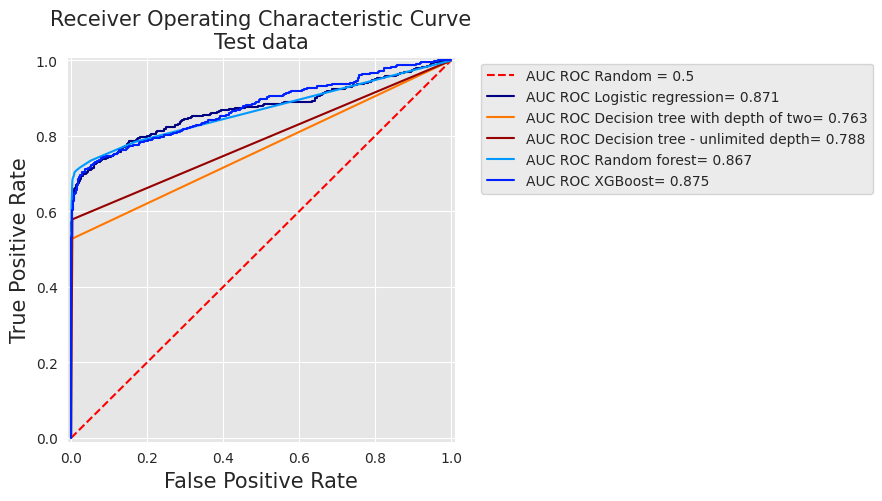

In [13]:
roc_curve

In [14]:
test_df[test_df.TX_FRAUD==0].shape

(57879, 23)

In [15]:
test_df[test_df.TX_FRAUD==1].shape

(385, 23)

In [16]:
# 2 fraudulent and 8 genuine transactions
true_labels = [1,1,0,0,0,0,0,0,0,0]

# Probability of fraud for each transaction
fraud_probabilities = [0.9,0.35,0.45,0.4,0.2,0.2,0.2,0.1,0.1,0]

unique_thresholds = [1.1]+list(set(fraud_probabilities))
unique_thresholds.sort(reverse=True)

performance_metrics=threshold_based_metrics(fraud_probabilities, true_labels, unique_thresholds)
performance_metrics[['Threshold','Precision','TPR']]

,Threshold,Precision,TPR
0,1.10,1.000000,0.0
1,0.90,1.000000,0.5
2,0.45,0.500000,0.5
3,0.40,0.333333,0.5
4,0.35,0.500000,1.0
5,0.20,0.285714,1.0
6,0.10,0.222222,1.0
7,0.00,0.200000,1.0


In [17]:
def compute_AP(precision, recall):

    AP = 0

    n_thresholds = len(precision)

    for i in range(1, n_thresholds):

        if recall[i]-recall[i-1]>=0:

            AP = AP+(recall[i]-recall[i-1])*precision[i]

    return AP

In [18]:
%%capture
def get_template_pr_curve(ax, title,fs, baseline=0.5):
    ax.set_title(title, fontsize=fs)
    ax.set_xlim([-0.01, 1.01])
    ax.set_ylim([-0.01, 1.01])

    ax.set_xlabel('Recall (True Positive Rate)', fontsize=fs)
    ax.set_ylabel('Precision', fontsize=fs)

    ax.plot([0, 1], [baseline, baseline],'r--',label='AP Random = {0:0.3f}'.format(baseline))

precision = performance_metrics.Precision.values
recall = performance_metrics.TPR.values

pr_curve, ax = plt.subplots(figsize=(5,5))
get_template_pr_curve(ax, "Precision Recall (PR) Curve",fs=15,baseline=sum(true_labels)/len(true_labels))
AP2 = metrics.average_precision_score(true_labels, fraud_probabilities)
AP = compute_AP(precision, recall)
ax.step(recall, precision, 'b', color='blue', label = 'AP Classifier = {0:0.3f}'.format(AP))
ax.legend(loc = 'lower right')

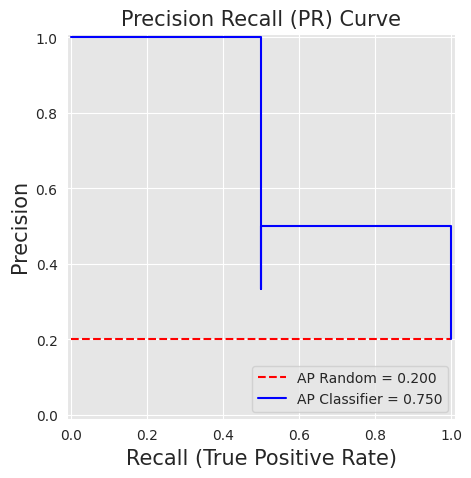

In [19]:
pr_curve

In [20]:
%%capture
pr_curve, ax = plt.subplots(1, 1, figsize=(6,6))
cmap = plt.get_cmap('jet')
colors={'Logistic regression':cmap(0), 'Decision tree with depth of two':cmap(200),
        'Decision tree - unlimited depth':cmap(250),
        'Random forest':cmap(70), 'XGBoost':cmap(40)}

get_template_pr_curve(ax, "Precision Recall (PR) Curve\nTest data",fs=15,baseline=sum(test_df[output_feature])/len(test_df[output_feature]))

for classifier_name in classifiers_dictionary:

    model_and_predictions=fitted_models_and_predictions_dictionary[classifier_name]

    precision, recall, threshold = metrics.precision_recall_curve(test_df[output_feature], model_and_predictions['predictions_test'])
    precision=precision[::-1]
    recall=recall[::-1]

    AP = metrics.average_precision_score(test_df[output_feature], model_and_predictions['predictions_test'])

    ax.step(recall, precision, 'b', color=colors[classifier_name], label = 'AP {0}= {1:0.3f}'.format(classifier_name,AP))
    ax.legend(loc = 'upper left',bbox_to_anchor=(1.05, 1))


plt.subplots_adjust(wspace=0.5, hspace=0.8)

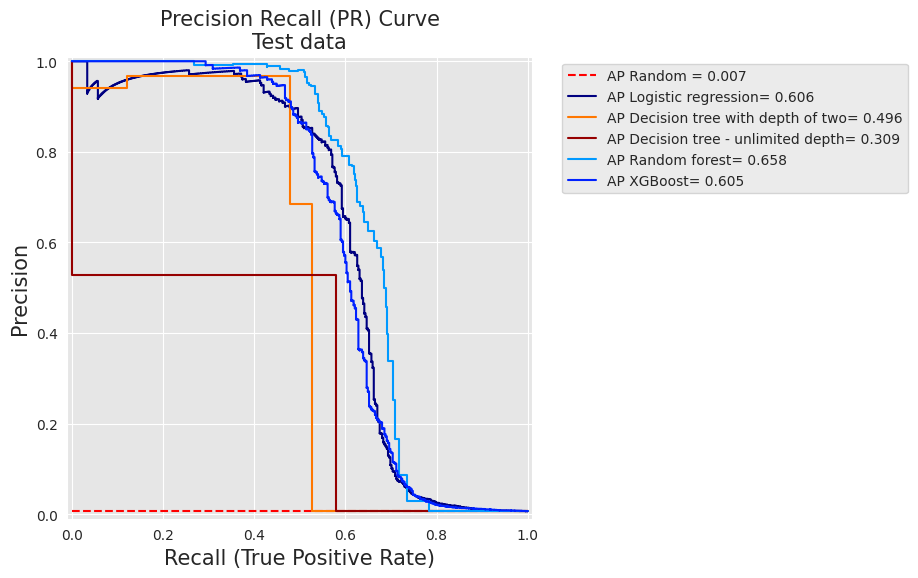

In [21]:
pr_curve